# XGBoost Months: Prediction per Cluster with selected Weather Variables (according to Weather Variables)

## Loading and Cleaning the Data

### Loading Packages, Datasets & Defining Functions

In [1]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np

# Data Viz -----------------------------------
import matplotlib.pyplot as plt

# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing # scaling data

In [2]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):

    if HEX.shape == (112, 3):
        print(HEX.shape,": Shape is correct.")
    else:
        print(HEX.shape,": Shape is **INCORRECT!**")

    if HEX["CODIGO MUNICIPIO"].nunique() == 112:
        print(HEX["CODIGO MUNICIPIO"].nunique(),": Number of unique municipalities is correct.")
    else:
        print(HEX["CODIGO MUNICIPIO"].nunique(),": Number of unique municipalities is **INCORRECT!**")
    
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

In [3]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_months/WBds03_QUEENtrain_months_DataWig.csv") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_months/WBds03_QUEENpredict_months_DataWig.csv") #2020 prediction df
queen_clusters = pd.read_csv("../../../Other_open_data/cluster.csv")

### Further Clean the Data

In [4]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'CODIGO MUNICIPIO')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'CODIGO MUNICIPIO')

In [5]:
# Remove the Municipalities that we did not assign a Cluster since there was not reliable data for us to predict 

queen_train = queen_train.loc[~queen_train.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()
queen_predict = queen_predict.loc[~queen_predict.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()

## Generate a ML Model for Each Cluster

### Scale the Data to extract Feature Importance for Each Cluster

#### Arrange data into a features matrix and target vector

In [6]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_cluster1 = queen_train.loc[queen_train.Cluster == 0,"waspbust_id"]
y_cluster2 = queen_train.loc[queen_train.Cluster == 1,"waspbust_id"]
y_cluster3 = queen_train.loc[queen_train.Cluster == 2,"waspbust_id"]
y_cluster4 = queen_train.loc[queen_train.Cluster == 3,"waspbust_id"]

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster1 = queen_train.loc[queen_train.Cluster == 0,:].iloc[:,7:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
X_cluster2 = queen_train.loc[queen_train.Cluster == 1,:].iloc[:,7:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
X_cluster3 = queen_train.loc[queen_train.Cluster == 2,:].iloc[:,7:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
X_cluster4 = queen_train.loc[queen_train.Cluster == 3,:].iloc[:,7:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster1 = queen_predict.loc[queen_predict.Cluster == 0,:].iloc[:,5:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
queen_predict2020_cluster2 = queen_predict.loc[queen_predict.Cluster == 1,:].iloc[:,5:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
queen_predict2020_cluster3 = queen_predict.loc[queen_predict.Cluster == 2,:].iloc[:,5:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()
queen_predict2020_cluster4 = queen_predict.loc[queen_predict.Cluster == 3,:].iloc[:,5:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()

In [7]:
# Scale the datasets using MinMaxScaler for each cluster

X_scaled_cluster1 = preprocessing.minmax_scale(X_cluster1) # this creates a numpy array
X_scaled_cluster1 = pd.DataFrame(X_scaled_cluster1,index=X_cluster1.index,columns=X_cluster1.columns) # create a Pandas Dataframe == X

X_scaled_cluster2 = preprocessing.minmax_scale(X_cluster2) # this creates a numpy array
X_scaled_cluster2 = pd.DataFrame(X_scaled_cluster2,index=X_cluster2.index,columns=X_cluster2.columns) # create a Pandas Dataframe == X

X_scaled_cluster3 = preprocessing.minmax_scale(X_cluster3) # this creates a numpy array
X_scaled_cluster3 = pd.DataFrame(X_scaled_cluster3,index=X_cluster3.index,columns=X_cluster3.columns) # create a Pandas Dataframe == X

X_scaled_cluster4 = preprocessing.minmax_scale(X_cluster4) # this creates a numpy array
X_scaled_cluster4 = pd.DataFrame(X_scaled_cluster4,index=X_cluster4.index,columns=X_cluster4.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [8]:
# selecting the XGBoost model and fitting with the train data

model_cluster1 = XGBRegressor()
model_cluster2 = XGBRegressor()
model_cluster3 = XGBRegressor()
model_cluster4 = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [9]:
# selecting the XGBoost model and fitting with the train data for each cluster

print(model_cluster1.fit(X_scaled_cluster1, y_cluster1),"\n")
print(model_cluster2.fit(X_scaled_cluster2, y_cluster2),"\n")
print(model_cluster3.fit(X_scaled_cluster3, y_cluster3),"\n")
print(model_cluster4.fit(X_scaled_cluster4, y_cluster4))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state

#### Selecting the Relevant Variables and filtering according to the results

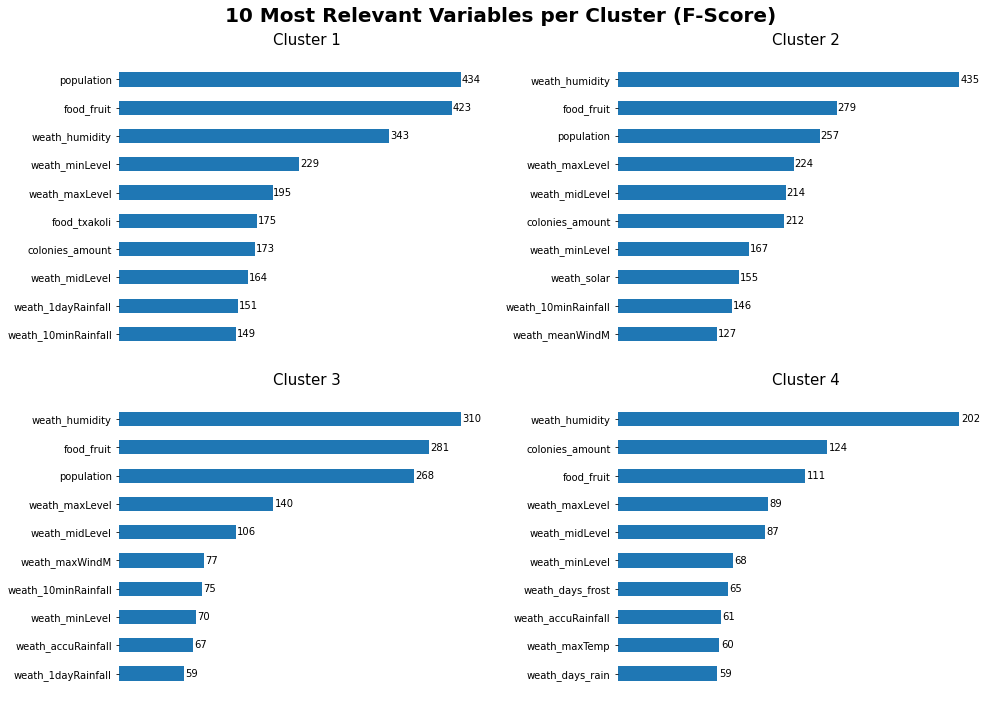

In [10]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

fig = plt.figure(figsize=(14, 10))
fig.suptitle('10 Most Relevant Variables per Cluster (F-Score)', fontsize=20, weight="heavy")

ax1 = plt.subplot(2, 2, 1,frame_on=False)
xgb.plot_importance(model_cluster1,height=0.5,ax=ax1,xlabel=None,ylabel=None,max_num_features=10,grid=False)
ax1.set_title('Cluster 1',size=15)
ax1.set_xticklabels([])
ax1.set_xticks([])

ax2 = plt.subplot(2, 2, 2,frame_on=False)
xgb.plot_importance(model_cluster2,height=0.5,ax=ax2,xlabel=None,ylabel=None,max_num_features=10,grid=False)
ax2.set_title('Cluster 2',size=15)
ax2.set_xticklabels([])
ax2.set_xticks([])

ax3 = plt.subplot(2, 2, 3,frame_on=False)
xgb.plot_importance(model_cluster3,height=0.5,ax=ax3,xlabel=None,ylabel=None,max_num_features=10,grid=False)
ax3.set_title('Cluster 3',size=15)
ax3.set_xticklabels([])
ax3.set_xticks([])

ax4 = plt.subplot(2, 2, 4,frame_on=False)
xgb.plot_importance(model_cluster4,height=0.5,ax=ax4,xlabel=None,ylabel=None,max_num_features=10,grid=False)
ax4.set_title('Cluster 4',size=15)
ax4.set_xticklabels([])
ax4.set_xticks([])

plt.tight_layout()
plt.show()

In [11]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# selecting the train X & y variables

# Y/Response variable have been defined previously

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_cluster1 = queen_train.loc[queen_train.Cluster == 0,["population","food_fruit","weath_humidity"]].copy()
X_cluster2 = queen_train.loc[queen_train.Cluster == 1,["weath_humidity","food_fruit"]].copy()
X_cluster3 = queen_train.loc[queen_train.Cluster == 2,["weath_humidity","population","food_fruit"]].copy()
X_cluster4 = queen_train.loc[queen_train.Cluster == 3,["weath_humidity","colonies_amount","food_fruit"]].copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020_cluster1 = queen_predict.loc[queen_predict.Cluster == 0,["population","food_fruit","weath_humidity"]].copy()
queen_predict2020_cluster2 = queen_predict.loc[queen_predict.Cluster == 1,["weath_humidity","food_fruit"]].copy()
queen_predict2020_cluster3 = queen_predict.loc[queen_predict.Cluster == 2,["weath_humidity","population","food_fruit"]].copy()
queen_predict2020_cluster4 = queen_predict.loc[queen_predict.Cluster == 3,["weath_humidity","colonies_amount","food_fruit"]].copy()

### Choose a class of model by importing the appropriate estimator class

In [12]:
# selecting the XGBoost model and fitting with the train data

model_cluster1 = XGBRegressor()
model_cluster2 = XGBRegressor()
model_cluster3 = XGBRegressor()
model_cluster4 = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [13]:
# refitting the model

print(model_cluster1.fit(X_cluster1, y_cluster1),"\n")
print(model_cluster2.fit(X_cluster2, y_cluster2),"\n")
print(model_cluster3.fit(X_cluster3, y_cluster3),"\n")
print(model_cluster4.fit(X_cluster4, y_cluster4))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [15]:
# make a prediction

prediction_2020_cluster1 = model_cluster1.predict(queen_predict2020_cluster1)
prediction_2020_cluster2 = model_cluster2.predict(queen_predict2020_cluster2)
prediction_2020_cluster3 = model_cluster3.predict(queen_predict2020_cluster3)
prediction_2020_cluster4 = model_cluster4.predict(queen_predict2020_cluster4)

## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [16]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = 0

In [17]:
# Add the cluster predictions to the newly created column 

queen_predict.loc[queen_predict.Cluster == 0,"nests_2020"] = prediction_2020_cluster1
queen_predict.loc[queen_predict.Cluster == 1,"nests_2020"] = prediction_2020_cluster2
queen_predict.loc[queen_predict.Cluster == 2,"nests_2020"] = prediction_2020_cluster3
queen_predict.loc[queen_predict.Cluster == 3,"nests_2020"] = prediction_2020_cluster4

In [18]:
# group by municip code
group_predict = queen_predict.groupby(by=["municip_code","municip_name"], as_index=False).sum()

In [19]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48022, 48071, 48088, 48074, 48051, 48020],\
             "NOMBRE MUNICIPIO":["Karrantza Harana/Valle de Carranza","Muskiz","Ubide","Urduña/Orduña","Lanestosa","Bilbao"],\
             "NIDOS 2020":[0,0,0,0,0,0]})

In [20]:
HEX = group_predict.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [21]:
# Final check

check_data(HEX)

(112, 3) : Shape is correct.
112 : Number of unique municipalities is correct.
The Total 2020 Nests' Prediction is 3547


In [ ]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210512_batch_XGmonths.csv", index=False)